In [674]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima.arima.utils import ndiffs, nsdiffs


import json

In [675]:
# f = open()
data_df = pd.read_json('src/api/data/AIR_Q_TU_Graz/output_chunk_6_cut_out_coarse_grained_1minute.json')


In [676]:
data_df


,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2,timestamp
0,20.764444,737.111111,10.087778,1.722222,0.375576,74.277780,17.724889,623.055544,2023-10-19 07:13:00
1,20.769000,738.500000,10.103000,1.450000,0.701922,74.280000,17.746500,625.550000,2023-10-19 07:14:00
2,20.763000,666.333333,10.164000,1.833333,0.610247,74.803333,17.807333,632.800000,2023-10-19 07:15:00
3,20.765556,717.444444,10.180111,1.611111,0.340111,73.571112,17.827889,644.177778,2023-10-19 07:16:00
4,20.771500,761.666667,10.200333,1.550000,0.410790,72.431667,17.863000,655.483333,2023-10-19 07:17:00
...,...,...,...,...,...,...,...,...,...
18282,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000,2023-10-31 23:55:00
18283,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000,2023-10-31 23:56:00
18284,20.787000,974.666667,11.586000,1.416667,0.413754,31.476667,18.545167,474.316667,2023-10-31 23:57:00
18285,20.788429,938.428571,11.592286,1.985714,0.575893,31.372857,18.543286,473.928571,2023-10-31 23:58:00


In [677]:
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])
data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df['timestamp'], unit="ms")) #.sort_index(ascending=True, inplace=False)
data_df = data_df.drop(columns=["timestamp"])



In [678]:
# pos = data_df.index[-1]
# data_df.loc[pos]
PERIODS1 = 12
data_df[data_df.index[-PERIODS1]:]["oxygen"]

timestamp
2023-10-31 23:48:00    20.782750
2023-10-31 23:49:00    20.782143
2023-10-31 23:50:00    20.786889
2023-10-31 23:51:00    20.786889
2023-10-31 23:52:00    20.788000
2023-10-31 23:53:00    20.788818
2023-10-31 23:54:00    20.788818
2023-10-31 23:55:00    20.787600
2023-10-31 23:56:00    20.787600
2023-10-31 23:57:00    20.787000
2023-10-31 23:58:00    20.788429
2023-10-31 23:59:00    20.788429
Name: oxygen, dtype: float64

In [679]:
train_data_size = int(data_df.shape[0] * 0.6)
df_train = data_df.iloc[:train_data_size]
df_test = data_df.iloc[train_data_size:]

In [680]:
df_test

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-26 22:05:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.009500,712.625000
2023-10-26 22:06:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.009500,712.625000
2023-10-26 22:07:00,20.780667,974.000000,12.643333,1.933333,0.508624,31.450000,19.011000,711.066633
2023-10-26 22:08:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.009818,711.400000
2023-10-26 22:09:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.009818,711.400000
...,...,...,...,...,...,...,...,...
2023-10-31 23:55:00,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000
2023-10-31 23:56:00,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000
2023-10-31 23:57:00,20.787000,974.666667,11.586000,1.416667,0.413754,31.476667,18.545167,474.316667


In [681]:
def scale(df):
  scaler = StandardScaler()
  scaler.fit(df)

        # Scale data using the previously defined scaler
  df = pd.DataFrame(scaler.transform(df.copy()), 
                      columns=df.columns, 
                      index=df.index)
  
  return df, scaler


def unscale(df, scaler):
  df = pd.DataFrame(scaler.inverse_transform(df), 
                  columns=df.columns, 
                  index=df.index)
  
  return df

In [682]:
PERIODS = 12

def test_stationarity_kpss_adf(data, periods_in_season=None):
    if periods_in_season:
        # Estimate the number of differences using an ADF test:
        kpss_n_diffs = nsdiffs(np.array(data).astype(float), test='ocsb', m=periods_in_season)  # -> 0
        print(f"Stationarity: KPSS Test result: should be seasonally differenced {kpss_n_diffs}")

        adf_n_diffs = nsdiffs(np.array(data).astype(float), test='ch', m=periods_in_season)  # -> 0
        print(f"Stationarity: ADF Test result: should be seasonally differenced {adf_n_diffs}")
    else:
        # Estimate the number of differences using an ADF test:
        kpss_n_diffs = ndiffs(np.array(data).astype(float), test='kpss', max_d=2)  # -> 0
        print(f"Stationarity: KPSS Test result: should be differenced {kpss_n_diffs}")

        adf_n_diffs = ndiffs(np.array(data).astype(float), test='adf', max_d=2)  # -> 0
        print(f"Stationarity: ADF Test result: should be differenced {adf_n_diffs}")

    return {
        "kpss": { "isStationary": kpss_n_diffs == 0, "ndiffs": kpss_n_diffs },\
        "adf" : { "isStationary": adf_n_diffs == 0, "ndiffs": adf_n_diffs },
    }

def get_all_needed_diffs(df, periods_in_season=None):
    selected_ndiffs_dict = {}
    for i in range(len(df.columns)):
        stationarity_test_result = test_stationarity_kpss_adf(df[df.columns[i]], periods_in_season)
        selected_ndiffs = np.max([stationarity_test_result["kpss"]["ndiffs"], stationarity_test_result["adf"]["ndiffs"]])
        if periods_in_season:
            selected_ndiffs_dict[df.columns[i]] = selected_ndiffs
        else:
            selected_ndiffs_dict[df.columns[i]] = selected_ndiffs 

    return selected_ndiffs_dict

def convert_data_to_stationary(df, periods_in_season=None):
    df_diff = df.copy()
    first_elements = {}
    seasonal_first_elements = {}

    if periods_in_season:
        selected_nsdiffs = get_all_needed_diffs(df_diff, periods_in_season)

        for key, value in selected_nsdiffs.items():
            for i in range(value):
                existing_array = seasonal_first_elements.get(key, [])
                pos = df_diff.index[-PERIODS]
                seasonal_first_elements[key] = existing_array + [df_diff[pos:][key]]
                df_diff[key] = df_diff[key].diff(PERIODS)
    
    max_sdiff = max(selected_nsdiffs.values())
    df_diff = df_diff[(PERIODS*max_sdiff):]

    selected_ndiffs = get_all_needed_diffs(df_diff)
    # print(f"Selected ndiffs {selected_ndiffs}")
    # # Apply differencing to make data stationary
    for key, value in selected_ndiffs.items():
        print(f"ndiffs {key} - {value}")
        for i in range(value):
            existing_array = first_elements.get(key, [])
            pos = df_diff[key].index[-1]
            first_elements[key] = existing_array + [df_diff[pos:][key]]
            df_diff[key] = df_diff[key].diff()

    max_diff = max(selected_ndiffs.values())
    # print(f"MAX DIFF --- > normal: {max_diff} seasonal:{max_sdiff}")
    df_diff = df_diff[max_diff:]

    print(f"Deleted -> {len(df)} - {len(df_diff)}")

    return df_diff, selected_ndiffs, first_elements, selected_nsdiffs, seasonal_first_elements



In [683]:
data_df

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-19 07:13:00,20.764444,737.111111,10.087778,1.722222,0.375576,74.277780,17.724889,623.055544
2023-10-19 07:14:00,20.769000,738.500000,10.103000,1.450000,0.701922,74.280000,17.746500,625.550000
2023-10-19 07:15:00,20.763000,666.333333,10.164000,1.833333,0.610247,74.803333,17.807333,632.800000
2023-10-19 07:16:00,20.765556,717.444444,10.180111,1.611111,0.340111,73.571112,17.827889,644.177778
2023-10-19 07:17:00,20.771500,761.666667,10.200333,1.550000,0.410790,72.431667,17.863000,655.483333
...,...,...,...,...,...,...,...,...
2023-10-31 23:55:00,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000
2023-10-31 23:56:00,20.787600,944.400000,11.591000,2.020000,0.476600,31.594000,18.544600,474.820000
2023-10-31 23:57:00,20.787000,974.666667,11.586000,1.416667,0.413754,31.476667,18.545167,474.316667


In [684]:
data_df.iloc[0]

oxygen          20.764444
health         737.111111
dewpt           10.087778
TypPS            1.722222
gauss            0.375576
sound           74.277780
temperature     17.724889
co2            623.055544
Name: 2023-10-19 07:13:00, dtype: float64

In [685]:
def inverse_diff(s, last_observation):
    series_undifferenced = s.copy()
    series_undifferenced1 = pd.concat([last_observation, series_undifferenced], axis=0)
    for i in range(len(series_undifferenced)):
        pos = series_undifferenced.index[i]
        series_undifferenced1[pos] = series_undifferenced.iloc[i]+series_undifferenced1.iloc[i]
    return series_undifferenced1

def df_inv_transform_every_ds_variable(df_transformed, diff_order, first_elements):
    for key, value in diff_order.items():
        for i in range(value):
            print(f"VALUE : {i}")
            df_transformed[key] = inverse_diff(df_transformed[key], first_elements[key][-1-i])
    return df_transformed

def df_inv_transformation(pred, diff_order, first_elements, seasonal_diff_order=None, seasonal_first_elements=None):
    df_transformed = pred.copy()

    df_transformed = df_inv_transform_every_ds_variable(df_transformed, diff_order, first_elements)

    if seasonal_diff_order and seasonal_first_elements:
        df_transformed = df_inv_transform_every_ds_variable(df_transformed, seasonal_diff_order, seasonal_first_elements)
    
    return df_transformed

In [686]:
df_train.tail()

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-26 22:00:00,20.785400,950.500000,12.642800,2.010000,0.671963,31.3030,19.008800,712.890000
2023-10-26 22:01:00,20.785400,950.500000,12.642800,2.010000,0.671963,31.3030,19.008800,712.890000
2023-10-26 22:02:00,20.785000,975.000000,12.644000,1.300000,0.004300,31.2900,19.010000,712.700000
2023-10-26 22:03:00,20.781333,923.333333,12.641333,2.433333,0.580234,31.4500,19.007333,708.600000
2023-10-26 22:04:00,20.786250,962.750000,12.644250,1.475000,0.460647,31.2975,19.009750,709.999987


In [701]:
df_train_transformed, diff_order, first_elements, seasonal_diff_order, seasonal_first_elements  = convert_data_to_stationary(df_train, PERIODS)
# df_train_transformed, df_train_transformed_scaler = scale(df_train_transformed)
# df_diff, selected_ndiffs, first_elements, selected_nsdiffs, seasonal_first_elements
print(f"Delta {len(df_train) - len(df_train_transformed)} elements")
df_testtt = pd.concat([df_train.tail(2), df_test], axis=0) # tail equals hardcoded selected diff
df_test_transformed, d, s, a, b = convert_data_to_stationary(df_testtt, PERIODS)
# df_test_transformed, df_test_transformed_scaler = scale(df_test_transformed)
df_test_transformed

Stationarity: KPSS Test result: should be seasonally differenced 0
Stationarity: ADF Test result: should be seasonally differenced 0
Stationarity: KPSS Test result: should be seasonally differenced 0
Stationarity: ADF Test result: should be seasonally differenced 0
Stationarity: KPSS Test result: should be seasonally differenced 0
Stationarity: ADF Test result: should be seasonally differenced 0
Stationarity: KPSS Test result: should be seasonally differenced 0
Stationarity: ADF Test result: should be seasonally differenced 0
Stationarity: KPSS Test result: should be seasonally differenced 0
Stationarity: ADF Test result: should be seasonally differenced 0
Stationarity: KPSS Test result: should be seasonally differenced 0
Stationarity: ADF Test result: should be seasonally differenced 0
Stationarity: KPSS Test result: should be seasonally differenced 0
Stationarity: ADF Test result: should be seasonally differenced 0
Stationarity: KPSS Test result: should be seasonally differenced 0
St

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-26 22:05:00,-0.005250,-17.250000,-0.002250,0.750000,0.550056,-0.005000,-0.002667,1.225025
2023-10-26 22:06:00,0.000000,0.000000,0.000000,0.000000,0.550056,0.000000,0.000250,-2.625013
2023-10-26 22:07:00,-0.000333,28.500000,0.001333,-0.291667,0.508624,0.157500,0.001500,-1.558367
2023-10-26 22:08:00,-0.004667,-15.454545,-0.000515,-0.269697,0.543214,-0.172727,-0.002682,1.891733
2023-10-26 22:09:00,0.000000,0.000000,0.000000,0.000000,0.543214,0.000000,0.001182,-0.333367
...,...,...,...,...,...,...,...,...
2023-10-31 23:55:00,-0.001218,6.218182,0.006727,0.474545,0.476600,0.231273,0.003055,1.120000
2023-10-31 23:56:00,0.000000,0.000000,0.000000,0.000000,0.476600,0.000000,-0.003055,-1.120000
2023-10-31 23:57:00,-0.000600,30.266667,-0.005000,-0.603333,0.413754,-0.117333,0.000567,-0.503333


In [688]:
diff_order

{'oxygen': 1,
 'health': 1,
 'dewpt': 1,
 'TypPS': 1,
 'gauss': 0,
 'sound': 1,
 'temperature': 1,
 'co2': 1}

In [702]:
# df_test_transformed = unscale(df_test_transformed, df_test_transformed_scaler)
df_forecast_original = df_inv_transformation(df_test_transformed, diff_order, first_elements, seasonal_diff_order, seasonal_first_elements)


VALUE : 0
VALUE : 0
VALUE : 0
VALUE : 0
VALUE : 0
VALUE : 0
VALUE : 0


In [690]:
df_forecast_original.head(30)

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-26 22:05:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.007083,711.225013
2023-10-26 22:06:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.007333,708.600000
2023-10-26 22:07:00,20.780667,974.000000,12.643333,1.933333,0.508624,31.450000,19.008833,707.041633
2023-10-26 22:08:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.006152,708.933367
2023-10-26 22:09:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.007333,708.600000
2023-10-26 22:10:00,20.783800,940.000000,12.639200,1.920000,0.677151,31.326000,19.005515,709.659980
2023-10-26 22:11:00,20.783800,940.000000,12.639200,1.920000,0.677151,31.326000,19.007333,708.600000
2023-10-26 22:12:00,20.784500,972.666667,12.637667,1.350000,0.607951,31.415000,19.010333,707.823353
2023-10-26 22:13:00,20.779889,952.333333,12.633000,1.588889,0.372847,31.527778,19.011556,706.894433


In [691]:
df_test.head(20)

,oxygen,health,dewpt,TypPS,gauss,sound,temperature,co2
timestamp,,,,,,,,
2023-10-26 22:05:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.009500,712.625000
2023-10-26 22:06:00,20.781000,945.500000,12.642000,2.225000,0.550056,31.292500,19.009500,712.625000
2023-10-26 22:07:00,20.780667,974.000000,12.643333,1.933333,0.508624,31.450000,19.011000,711.066633
2023-10-26 22:08:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.009818,711.400000
2023-10-26 22:09:00,20.776000,958.545455,12.642818,1.663636,0.543214,31.277273,19.009818,711.400000
2023-10-26 22:10:00,20.783800,940.000000,12.639200,1.920000,0.677151,31.326000,19.008000,712.459980
2023-10-26 22:11:00,20.783800,940.000000,12.639200,1.920000,0.677151,31.326000,19.008000,712.459980
2023-10-26 22:12:00,20.784500,972.666667,12.637667,1.350000,0.607951,31.415000,19.011000,711.683333
2023-10-26 22:13:00,20.779889,952.333333,12.633000,1.588889,0.372847,31.527778,19.015222,709.977767


<Axes: xlabel='timestamp'>

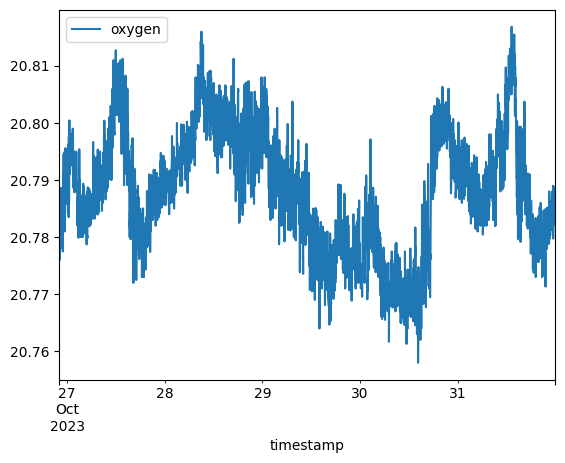

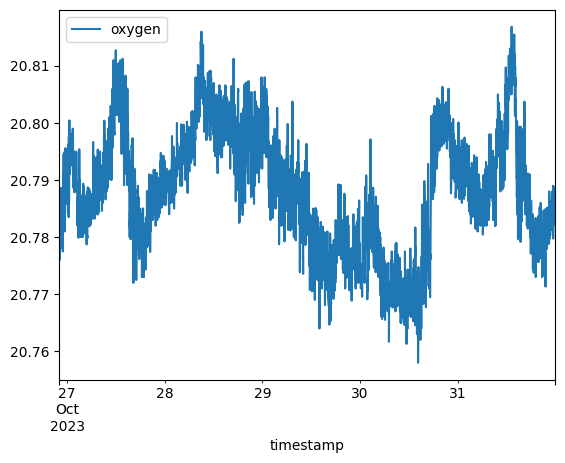

In [692]:
df_forecast_original.plot( y='oxygen')
df_test.plot( y='oxygen')

<Axes: xlabel='timestamp'>

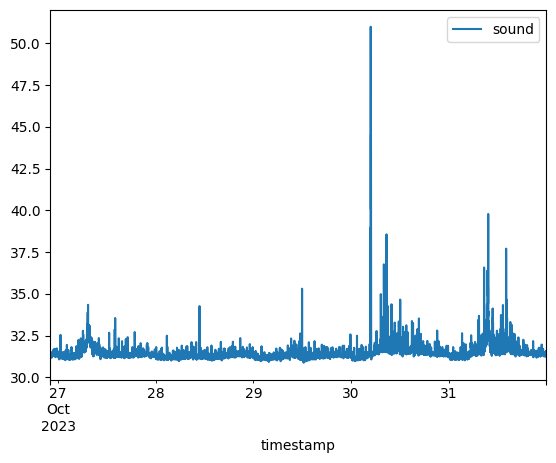

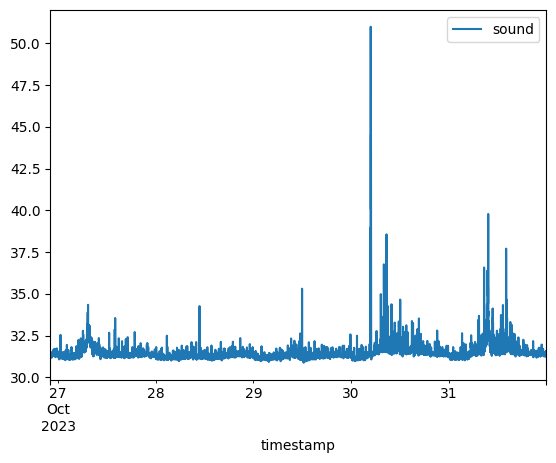

In [693]:
df_forecast_original.plot( y='sound')
df_test.plot( y='sound')

<Axes: xlabel='timestamp'>

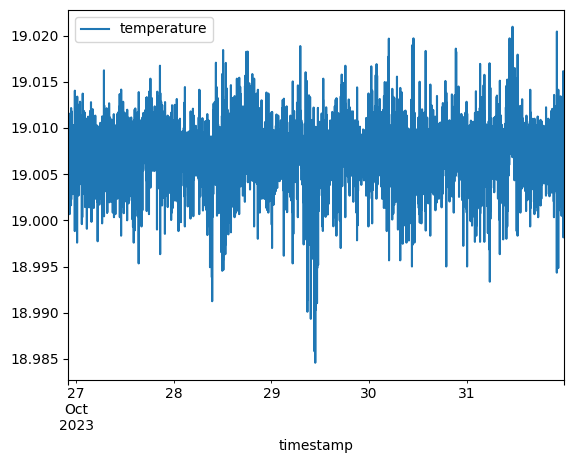

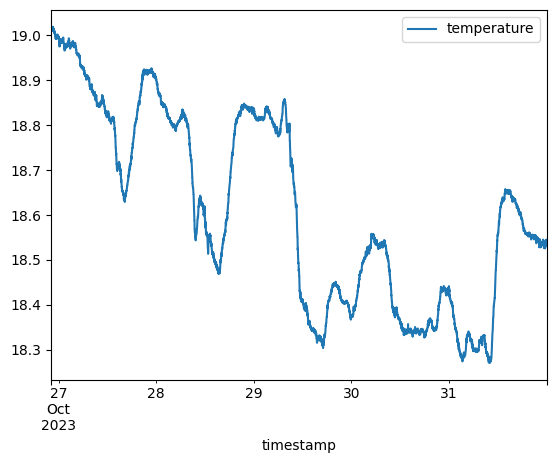

In [694]:
df_forecast_original.plot( y='temperature')
df_test.plot( y='temperature')

<Axes: xlabel='timestamp'>

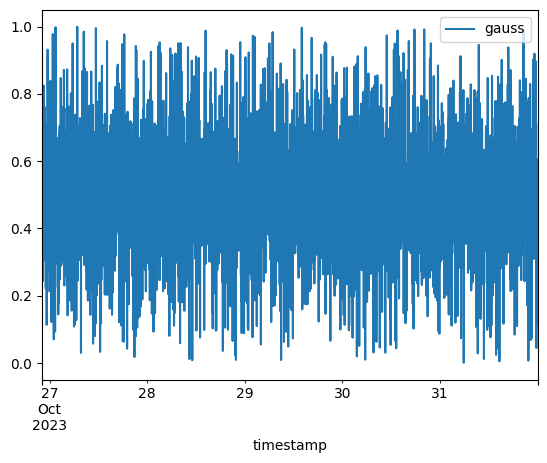

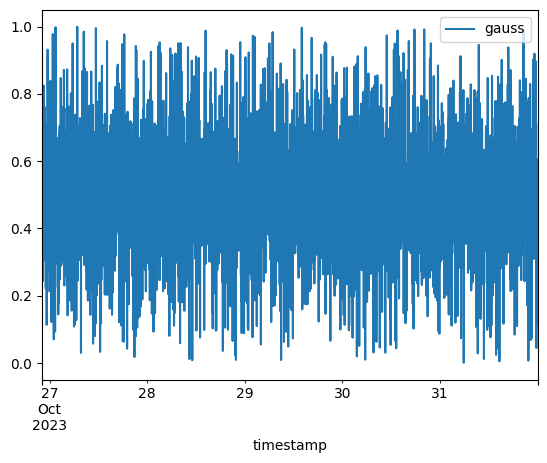

In [695]:
df_forecast_original.plot( y='gauss')
df_test.plot( y='gauss')

In [696]:
data_df.size

146296

In [697]:
data_df.duplicated().value_counts()
data_df = data_df.drop_duplicates()



In [698]:
data_df.size

105952

In [699]:
data_df_1m = data_df.groupby(pd.Grouper(key='timestamp', freq='1min')).mean()

KeyError: 'The grouper name timestamp is not found'

In [ ]:
data_df_1m

In [ ]:
df_filled = data_df_1m.bfill()

In [ ]:
df_filled

In [ ]:
my_range_in1m = pd.date_range(start=df_filled.index.min(), end=df_filled.index.max(), freq='1min')


In [ ]:
len(my_range_in1m[~my_range_in1m.isin(df_filled.index)])


In [ ]:
df_filled["timestamp"] = df_filled.index

In [ ]:
df_filled.to_json('./src/api/data/AIR_Q_TU_Graz/output_chunk_6_cut_out_coarse_grained_1minute.json', orient="records")

In [ ]:
grouped = data_df.groupby('Entity')

In [ ]:
data_df['Entity'].unique()

In [ ]:
data_df = data_df[data_df["Entity"] == 'Austria']

In [ ]:
data_df

In [ ]:
data_df.isna().sum()

In [ ]:
data_df.index = pd.DatetimeIndex(pd.to_datetime(data_df["Day"])) #.sort_index(ascending=True, inplace=False)


In [ ]:
data_df

In [ ]:
my_range = pd.date_range(start=data_df['Day'].min(), end=data_df['Day'].max(), freq='D')


In [ ]:
len(my_range[~my_range.isin(data_df.index)])


In [ ]:
my_range.drop_duplicates()

In [ ]:
print(data_df.shape)
new_df = pd.DataFrame()
new_df.index = my_range
new_df["Day"] = my_range
data_df = pd.merge(data_df, new_df, how="outer", right_index=True, left_index=True, validate="many_to_many")

In [ ]:
data_df.index.drop_duplicates()
print(data_df)


In [ ]:
data_df = data_df.groupby(data_df.index).last()

In [ ]:
data_df = data_df.drop_duplicates(keep='last')

In [ ]:
print(f"Duplicates: {data_df.index.duplicated()}")


In [ ]:
data_df = data_df.drop(columns=['Day_x', 'Day_y'])


In [ ]:
data_df["Day"] = data_df.index

In [ ]:
data_df.isna().sum()

In [ ]:
data_df = data_df.fillna(0)

In [ ]:
data_df

In [ ]:
data_df1 = pd.read_csv('src/api/data/weekly-covid-deaths.csv')

In [ ]:
grouped = data_df1.groupby('Entity')


In [ ]:
data_df1 = data_df1[data_df1["Entity"] == 'Austria']

In [ ]:
data_df1.isna().sum()

In [ ]:
data_df1.index = pd.DatetimeIndex(pd.to_datetime(data_df1["Day"])) #.sort_index(ascending=True, inplace=False)


In [ ]:
data_df = data_df.drop(columns=['Entity', 'Code'])
data_df

In [ ]:
data_df1 = data_df1.drop(columns=['Entity', 'Code'])
data_df1

In [ ]:
joint = data_df.join(data_df1, how='inner', on="Day")

In [ ]:
joint

In [ ]:
joint["timestamp"] = joint.index

In [ ]:
joint.to_json('./src/api/data/non-cumulative-deaths-and-cases-covid_14-08-24_Austria.json', orient="records")